<a href="https://colab.research.google.com/github/bustardchad/ML_Turb/blob/main/Image_Spectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Analysis: Gaussian Filtering

Analyzes how a CNN trained to differentiate MHD-only vs MHD+cosmic ray images
classifies images that have been gaussian smoothed to varying extents.
As we'll see, this smoothing apparently mocks the effects of cosmic rays, which act as a drag force on
fluctuations, effectively smoothing out sharp density features.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset, random_split
import pdb
import os

import seaborn as sn
import pandas as pd

!pip install cmasher
!pip install torchmetrics

!pip install torchinfo
!pip install tensorboard
from torchinfo import summary

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.5/531.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.3 MB/s eta 0:00:00


'cpu'

In [2]:
# configuration for training
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    sim_type = 'classify'
    inference = True
    data_presplit = True # whether data has already been split into training, val, test
    fileDirArr = ['MHD_beta10_projection', 'CR_Advect_beta10_projection', 'CR_Diff_Fiducial_beta10_projection', 'CR_Diff100_beta10_projection', 'CR_withStreaming_beta10_projection']
    #fileDirArr = ['MHD_beta10', 'CR_Diff_Fiducial_beta10']
    field_list = ['density']
    projection_depth = 1
    killPwr = False
    num_classes = 5
    train_frac = 0.6
    batch_size = 64
    use_transforms = True # add horizontal and vertical flipped versions
    augment_with_transforms = False
    flip_prob = 0.5
    data_sample_fraction = 0.5
    epochs = 25
    stop_early = True
    patience = 5
    run_locally = True # if running on my computer, take files from local directory instead of downloading them
    run_colab = True
    path_to_dir = 'drive/MyDrive/Turb_Sims/Image_Cubes/Multiple_Snapshots_Large/Full_Power/'
    dataset_size = 'small'
    hold_out_test_set = True
    save_dir = 'runs/'
    run_name = 'MHD_CRTransport_FullPwr_allClasses_multiple_snapshots_small'

config = TrainingConfig()

In [3]:
# Download the relevant data from Google Drive
!pip install --upgrade --no-cache-dir gdown
import gdown

from google.colab import drive


if (config.run_locally==False):

    # Path for the FULL google drive file with turb sim data
    # url = "https://drive.google.com/drive/folders/1C9zPwEglOZI7CqiS4Rz2MESCJzS4wTd2"

    # Path for the smaller turb sim data files (without augmentation)
    #url = "https://drive.google.com/drive/folders/1YDXgeazcwfyciAGUv_sW-gHDy7e1k5wY"

    url = "https://drive.google.com/drive/folders/1zzwYNPSV42jyEQVErlbE-CyKGIustlHv"

    if config.killPwr:
      url = "https://drive.google.com/drive/folders/1B7N_x5Y1N0wH96vKubyQ86Oftaz2M8W9"


    #if not os.path.exists("Image_Cubes_noAugment"):
    gdown.download_folder(url)
else: # Access files on google drive directly
    drive.mount('/content/drive')

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Mounted at /content/drive


In [4]:
# If on Google Colab, need to clone repo to have access to helper files

!git clone https://github.com/bustardchad/ML_Turb
!pip install memory_profiler

import ML_Turb.utilities.load_data as load_data
import ML_Turb.utilities.interpret_CNN as interp
import ML_Turb.utilities.classify_setup as classify_setup

# load data
#train_dl, valid_dl, test_dl = load_data.preprocess(config)

Cloning into 'ML_Turb'...
remote: Enumerating objects: 477, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 477 (delta 22), reused 18 (delta 8), pack-reused 440
Receiving objects: 100% (477/477), 82.66 MiB | 10.24 MiB/s, done.
Resolving deltas: 100% (255/255), done.
Updating files: 100% (24/24), done.


Loading training file /train_MHD_beta10_projection_density_depth_1_small.npy for classification problem
Loading training file /train_CR_Advect_beta10_projection_density_depth_1_small.npy for classification problem
Loading training file /train_CR_Diff_Fiducial_beta10_projection_density_depth_1_small.npy for classification problem
Loading training file /train_CR_Diff100_beta10_projection_density_depth_1_small.npy for classification problem
Loading training file /train_CR_withStreaming_beta10_projection_density_depth_1_small.npy for classification problem


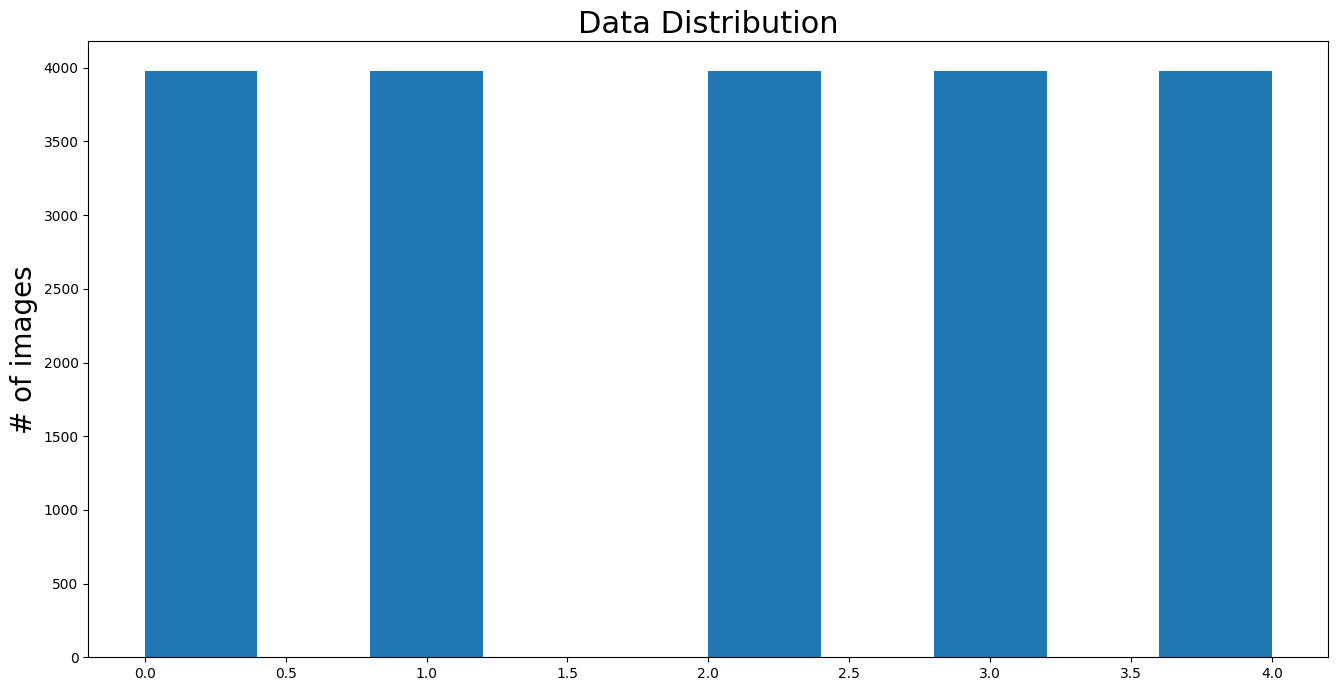

In [5]:
# Load data
torch.cuda.empty_cache()

# TODO: Log and store metrics and associated checkpoint files in folders
# TODO: Create a composite figure showing losses for different hyperparams

save_dir = 'runs/'
config.save_dir = save_dir
!mkdir 'runs'

batch_size = 512
config.batch_size = batch_size

# load data (this needs to be done in-loop when batch_size changes)
_, _, test_dl = load_data.preprocess(config)

In [9]:
# structure of the saved model

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.AdaptiveAvgPool2d(4), # works with any input size
    nn.Flatten(),
    nn.Linear(64*4*4,config.num_classes)
)
"""

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.AdaptiveAvgPool2d(4), # works with any input size
    nn.Flatten(),
    nn.Linear(32*4*4,config.num_classes)
)

"""
# path to checkpoint file
path_to_chk = ''
checkpoint_filename = 'fullpwr_batch_size_64lr_0.001_pdrop_0.25_checkpoint.pt'
# load the saved model checkpoint
model.load_state_dict(torch.load(path_to_chk + checkpoint_filename,map_location=torch.device('cpu')))
model.eval()

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU()
  (3): Dropout(p=0.25, inplace=False)
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): SiLU()
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): SiLU()
  (11): Dropout(p=0.25, inplace=False)
  (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): SiLU()
  (15): Dropout(p=0.25, inplace=False)
  (16): AdaptiveAvgPool2d(output_size=4)
  (17): Flatten(start_dim=1, end_dim=-1)
  (18): Linear(in_features=1024, out_features=5, bias=Tr

<ipython-input-10-dc8c2592eda6>:7: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


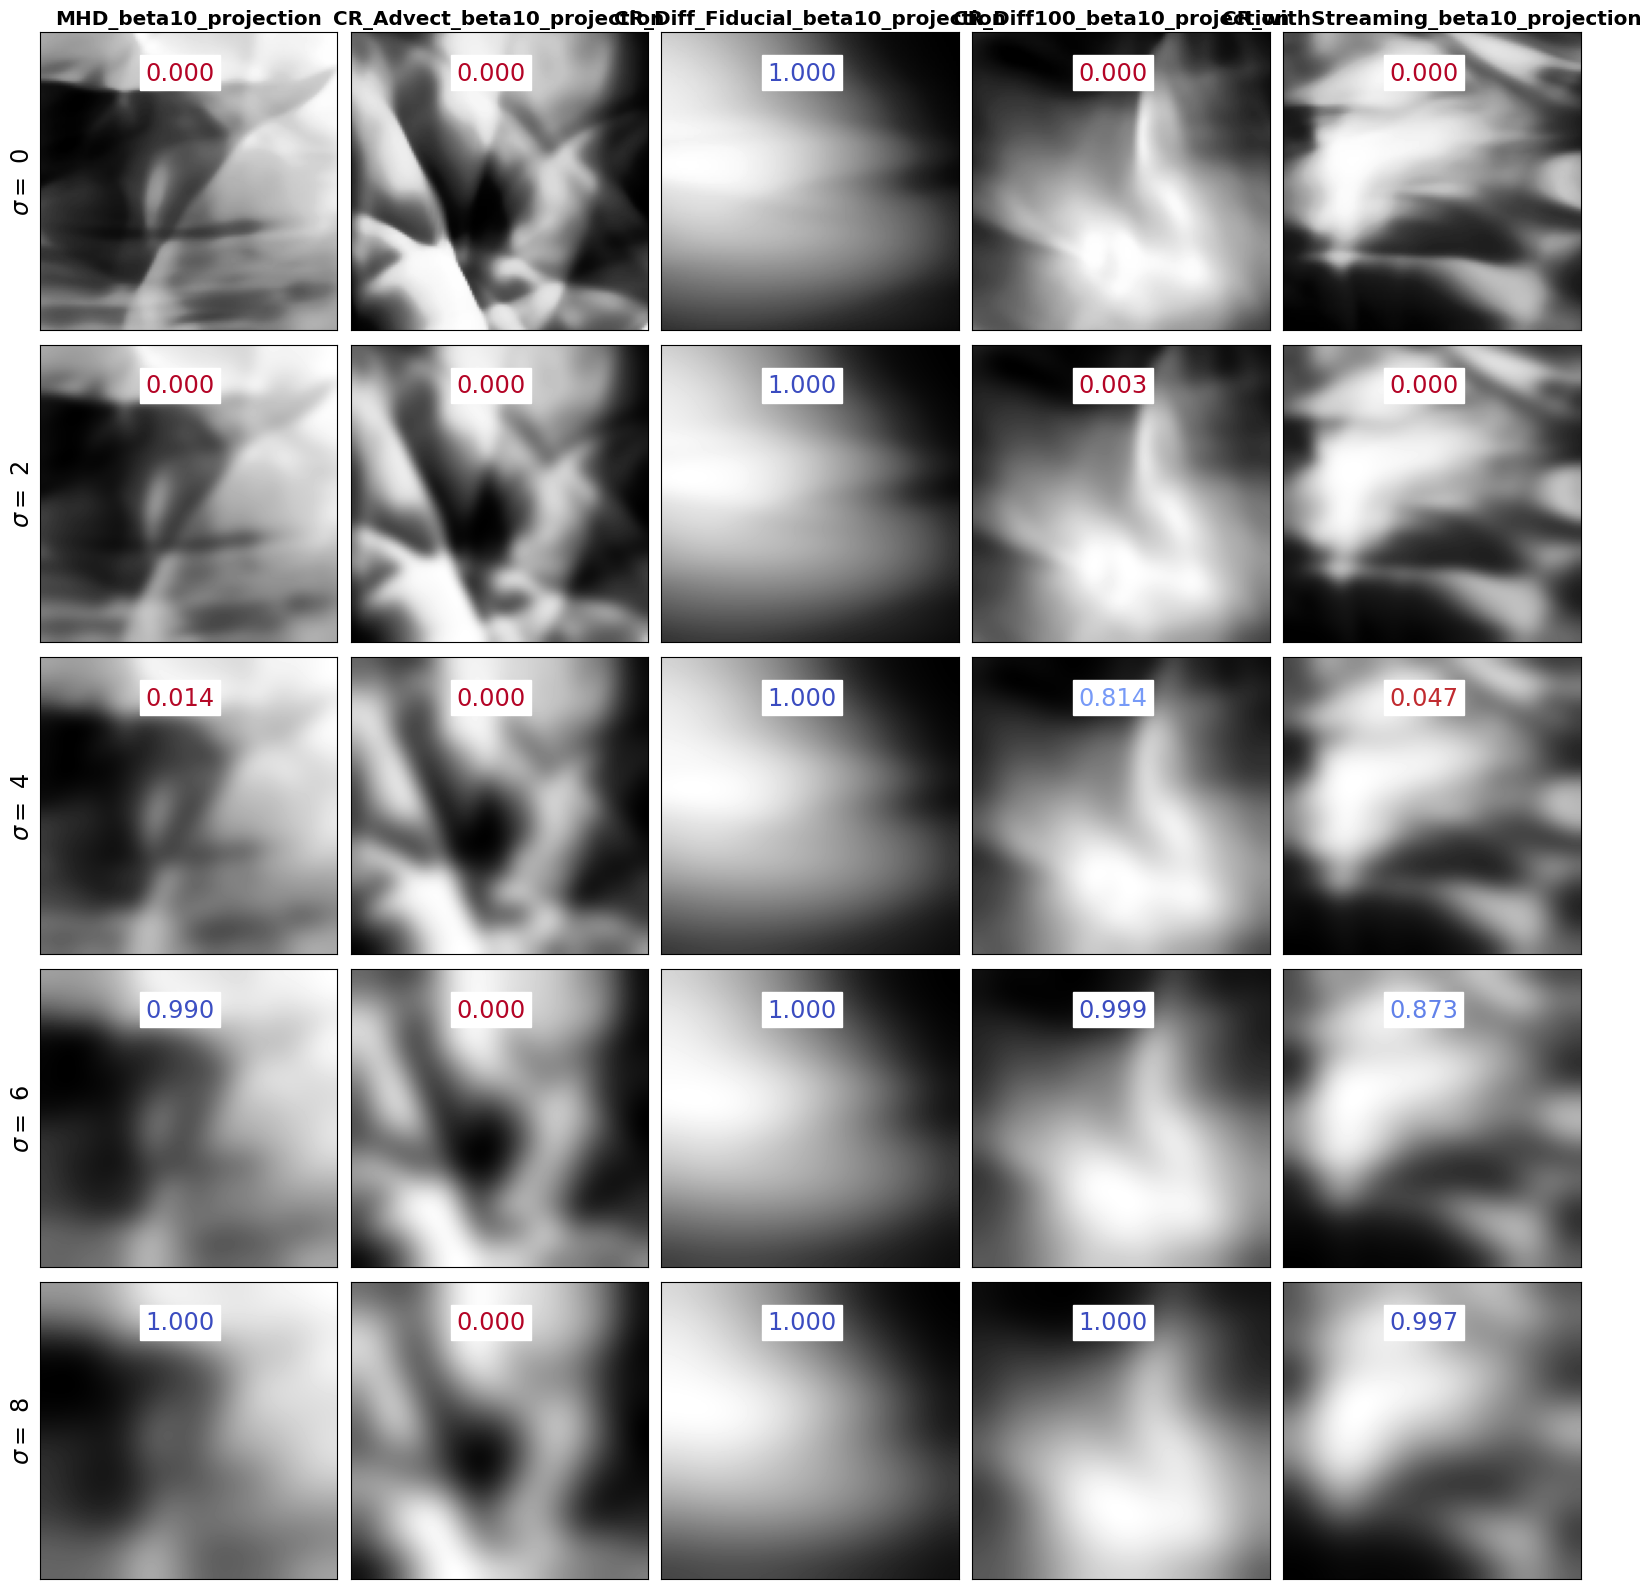

In [10]:
import matplotlib
from torchinfo.enums import RowSettings
# Show gaussian filtered images belonging to class sim_class and their power spectra
# Image titles are probability that the image belongs to sim_class
from ML_Turb.utilities.interpret_CNN import power1D

from scipy.ndimage.filters import gaussian_filter
import seaborn as sns

# MHD_beta10 == 0
# CR_Advect_beta10 == 1
# CR_Diff_Fiducial_beta10 == 2
# CR_Diff100_beta10 == 3
# CR_withStreaming_beta10 == 4

# which class to take images from and gaussian filter
# sim_class = 4

# which class to show probability of
prob_class = 2

n_examples = 5 # number of columns
n_sigmas = 5 # number of different sigmas

fig, axs = plt.subplots(n_sigmas, n_examples, figsize=(16,16))
#fig_spectra, axs_spectra = plt.subplots(n_sigmas, n_examples, figsize=(16,16))

# access a batch of labelled images
dataiter = iter(test_dl)
images, labels = next(dataiter)

# select n_example example images from each class
#k_norm, pwr_norm = power1D(images_to_plot[0,:,:,:]) # take FFT of 1st image in
                                              # batch with label == sim_class

# colormap for the probabilities
cnorm = matplotlib.colors.Normalize(vmin=0.01,vmax = 1,clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=cnorm,cmap=matplotlib.cm.coolwarm_r)

for i in range(0,n_sigmas):
    for j in range(0,n_examples):
        images_to_plot = images[labels==j]
        #plt_image = images_to_plot[j,:,:,:]
        plt_image = images_to_plot[0,:,:,:]

        # apply a Gaussian filter with standard deviation sigma to the image
        plt_image = torch.from_numpy(gaussian_filter(plt_image,sigma=float(2*i)))

        # create 1D power spectrum of filtered image
        #k, pwr = power1D(plt_image)

        #run inference on modified image
        output = model(plt_image.reshape(1,1,plt_image.shape[-2],plt_image.shape[-1]))
        output = nn.functional.softmax(output, dim=1) # makes it a probability for each class

        all_probs = output.tolist()[0]
        prob = all_probs[int(prob_class)] # grab probability that it was classified as class prob_class

        axs[i,j].imshow(plt_image.squeeze(),cmap='gray')
        axs[i,j].xaxis.set_tick_params(labelbottom=False)
        axs[i,j].yaxis.set_tick_params(labelleft=False)

        # Hide X and Y axes tick marks
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        #ttl = '{:2f},{:2f}'.format([])
        #axs[i,j].set_title(all_probs[j])
        #axs[i,j].set_title('{:.3f}'.format(prob),color=mapper.to_rgba(prob),size='xx-large',pad=-8.0)
        axs[i,j].text(x=45,y=20,s='{:.3f}'.format(prob),color=mapper.to_rgba(prob),size='xx-large',backgroundcolor='w')
        #axs_spectra[i,j].loglog(k,pwr*(k**2)/(pwr_norm*(k_norm**2)),label=r"k$^{2}$P(k)dk")
        #axs_spectra[i,j].set_title('{:.3f}'.format(prob))
        #axs_spectra[i,j].set_xlim(1,30)
        #axs_spectra[i,j].set_ylim(1.E-1,2.0)

rows = [r'$\sigma =$ {}'.format(2*row) for row in range(0, n_sigmas)]

cols = config.fileDirArr
#new_rows = []
#for i in rows:
#    new_rows.extend(i)

for ax, col in zip(axs[0], cols):
    ax.set_title(col,color="k",pad=6.0,size='x-large',fontweight='semibold')

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='xx-large')

fig.tight_layout()
#fig_spectra.tight_layout()
#plt.legend()
plt.savefig("Gaussian_Filter_allClasses_ProbFiducialDiff_coloredProbs.pdf", dpi=600)
plt.show()

We see that, with increased filtering of the images, they are more and more classified as CR_Diff_Fiducial_beta10, showing that the network distinguishes that class by its "blurriness" and its lack of small-scale structure

Let's go one step further and plot the 1D power spectra for some simulations

<ipython-input-11-d02cd6a52b82>:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


[10822656.7495949  13258664.21796554 16175167.07112535 14916536.87393454
 15880432.17395172 14148335.8031656  15048860.88009967 14094327.19287027
 11787407.81263898 12880837.54861211 11391378.52420124 11967679.84771458
 10263089.24101187 10315790.3731804  10906427.72226856  8894094.96055349
  9066746.21806855  9295446.78972181  9383776.46304095 10037927.2791547
  8288949.69197109  8865768.12838265  9013466.34180595  9303890.84820991
  8491529.69851292  8895817.14656518  9481426.86019774  8722948.20424148
  9653580.79961353  8704567.02435868  9444548.40090846 10000008.66016988
  9434225.8094634   9147471.88016084  9528771.18292147  9781896.89937555
 10309794.97032833  9726910.31033902 10649118.24364806  9932865.01676838
 10978425.28598396 10762944.29088927 10730743.90054766 11638897.12919627
 11150275.54373611 12114350.39795892 11455908.79697782 11966245.94836755
 12190655.33073633 12506874.59559206 12873015.54996945 12494547.94748177
 14182696.19063034 13933449.21085424 13900719.686598

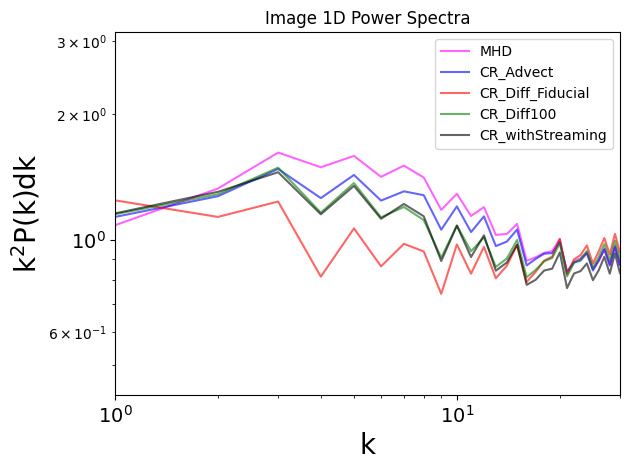

In [11]:
# make spectra for filtered images and color them by probabilities
from ML_Turb.utilities.interpret_CNN import power1D
import matplotlib as mpl
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns

# which class to calculate probability of
sim_class = 2

n_examples = 6 # number of columns
n_sigmas = 1 # number of different sigmas

# access a batch of labelled images
dataiter = iter(test_dl)
images, labels = next(dataiter)

images_class0 = images[labels==0]

#cvals = np.arange(1.E-2,1.0,1.E-2)
#colors = plt.cm.RdBu(cvals)
colors = ['magenta','blue','red','green','black']

#norm = mpl.colors.Normalize(vmin=cvals.min(), vmax=cvals.max())
#cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm_r)
#cmap.set_array([])

pwr_arr_label0 = np.zeros(64)
pwr_arr_label1 = np.zeros(64)
pwr_arr_label2 = np.zeros(64)
pwr_arr_label3 = np.zeros(64)
pwr_arr_label4 = np.zeros(64)

fig, axs = plt.subplots()

for i in range(0,n_sigmas):
    for j in range(0,len(images)):
        plt_image = images[j,:,:,:]
        label = labels[j]

       # create 1D power spectrum of filtered image
        k, pwr = power1D(plt_image)
        if label == 0:
          pwr_arr_label0 = np.vstack([pwr_arr_label0,pwr])
        if label == 1:
          pwr_arr_label1 = np.vstack([pwr_arr_label1,pwr])
        if label == 2:
          pwr_arr_label2 = np.vstack([pwr_arr_label2,pwr])
        if label == 3:
          pwr_arr_label3 = np.vstack([pwr_arr_label3,pwr])
        if label == 4:
          pwr_arr_label4 = np.vstack([pwr_arr_label4,pwr])


pwr_avg_label0 = np.average(pwr_arr_label0*k**2,axis=0)
pwr_avg_label1 = np.average(pwr_arr_label1*k**2,axis=0)
pwr_avg_label2 = np.average(pwr_arr_label2*k**2,axis=0)
pwr_avg_label3 = np.average(pwr_arr_label3*k**2,axis=0)
pwr_avg_label4 = np.average(pwr_arr_label4*k**2,axis=0)

pwr_std_label0 = np.std(pwr_arr_label0*k**2,axis=0)
pwr_std_label1 = np.std(pwr_arr_label1*k**2,axis=0)
pwr_std_label2 = np.std(pwr_arr_label2*k**2,axis=0)
pwr_std_label3 = np.std(pwr_arr_label3*k**2,axis=0)
pwr_std_label4 = np.std(pwr_arr_label4*k**2,axis=0)

print(pwr_avg_label0)
print(pwr_std_label0)

kvec = k
k = np.ones(len(kvec))
lw = 1.5
axs.loglog(kvec,pwr_avg_label0*(k**2)/1e7,color=colors[0],alpha=0.6,linewidth = lw, label="MHD")
axs.fill_between((k), ((pwr_avg_label0)*(k**2) - (pwr_std_label0)*(k**2))/1e7, ((pwr_avg_label0)*(k**2) + (pwr_std_label0)*(k**2))/1e7, facecolor=colors[0], alpha=0.2)
axs.loglog(kvec,pwr_avg_label1*(k**2)/1e7,color=colors[1],alpha=0.6,linewidth = lw,label = "CR_Advect")
axs.fill_between((k), ((pwr_avg_label1)*(k**2) - (pwr_std_label1)*(k**2))/1e7, ((pwr_avg_label1)*(k**2) + (pwr_std_label1)*(k**2))/1e7, facecolor=colors[1], alpha=0.2)
axs.loglog(kvec,pwr_avg_label2*(k**2)/1e7,color=colors[2],alpha=0.6,linewidth = lw,label="CR_Diff_Fiducial")
axs.fill_between((k), ((pwr_avg_label2)*(k**2) - (pwr_std_label2)*(k**2))/1e7, ((pwr_avg_label2)*(k**2) + (pwr_std_label2)*(k**2))/1e7, facecolor=colors[2], alpha=0.2)
axs.loglog(kvec,pwr_avg_label3*(k**2)/1e7,color=colors[3],alpha=0.6,linewidth = lw,label="CR_Diff100")
axs.fill_between((k), ((pwr_avg_label3)*(k**2) - (pwr_std_label3)*(k**2))/1e7, ((pwr_avg_label3)*(k**2) + (pwr_std_label3)*(k**2))/1e7, facecolor=colors[3], alpha=0.2)
axs.loglog(kvec,pwr_avg_label4*(k**2)/1e7,color=colors[4],alpha=0.6,linewidth = lw,label="CR_withStreaming")
axs.fill_between((k), ((pwr_avg_label4)*(k**2) - (pwr_std_label4)*(k**2))/1e7, ((pwr_avg_label4)*(k**2) + (pwr_std_label4)*(k**2))/1e7, facecolor=colors[4], alpha=0.2)
plt.legend()
plt.xlim(1,30)
plt.ylabel(r"k$^{2}$P(k)dk",fontsize=20)
plt.xlabel("k",fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Image 1D Power Spectra")
#fig.colorbar(cmap,label="P(CR_Diff_Fiducial_beta10)")

plt.tight_layout()
#plt.legend()
plt.savefig("Image_Spectra.pdf",dpi=600)
plt.show()
plt.close()

<ipython-input-22-82c746399d56>:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
<ipython-input-22-82c746399d56>:54: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cmap,label=r"Probability of CR_Diff_Fiducial")


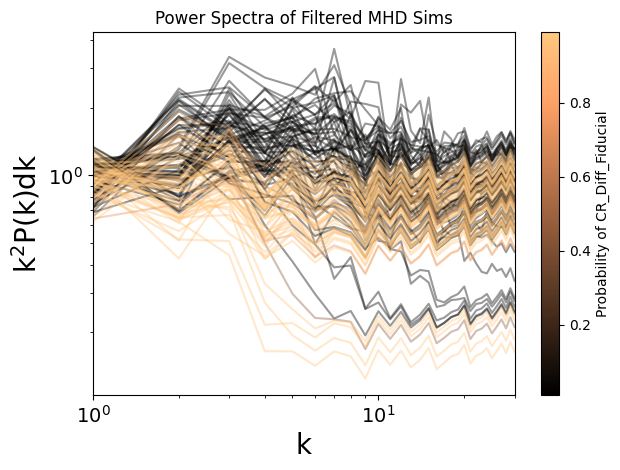

In [22]:
# make spectra for filtered images and color them by probabilities

import matplotlib as mpl
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns

# which class to calculate probability of
sim_class = 2

n_examples = 6 # number of columns
n_sigmas = 6 # number of different sigmas

# access a batch of labelled images
dataiter = iter(test_dl)
images, labels = next(dataiter)

images_class0 = images[labels==0][:20]

cvals = np.arange(1.E-2,1.0,1.E-2)
colors = plt.cm.copper(cvals)

norm = mpl.colors.Normalize(vmin=cvals.min(), vmax=cvals.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.copper)
cmap.set_array([])



fig, axs = plt.subplots()

for i in range(0,n_sigmas):
    for j in range(0,len(images_class0)):
        plt_image = images_class0[j,:,:,:]

        # apply a Gaussian filter with standard deviation sigma to the image
        plt_image = torch.from_numpy(gaussian_filter(plt_image,sigma=float(2*i)))

       # create 1D power spectrum of filtered image
        k, pwr = power1D(plt_image)

        #run inference on modified image
        output = model(plt_image.reshape(1,1,plt_image.shape[-2],plt_image.shape[-1]))
        output = nn.functional.softmax(output, dim=1) # makes it a probability for each class

        prob = output.tolist()[0][int(sim_class)] # grab probability that it was classified as class sim_class

        axs.loglog(k,pwr*(k**2)/1e7,label=r"k$^{2}$P(k)dk",color=colors[np.abs(cvals-prob).argmin()],alpha=0.4)

plt.xlim(1,30)
plt.ylabel(r"k$^{2}$P(k)dk",fontsize=20)
plt.xlabel("k",fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Power Spectra of Filtered MHD Sims")
fig.colorbar(cmap,label=r"Probability of CR_Diff_Fiducial")

plt.tight_layout()
#plt.legend()
plt.savefig("Prob_Filtered_Spectra.pdf",dpi=600)
plt.show()
plt.close()